In [23]:
import sklearn
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
from xgboost import plot_importance
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.svm import SVC

#custom
from py.helper import DataProcessing
from py.ml_metrics import plot_confusion_matrix, multiclass_logloss
from py.plotting import plot_tsne


#global
sns.set(rc={'figure.figsize':(15,15)})

In [2]:
# set K-mer length here
kmer = 4

In [3]:
orf1 = DataProcessing('coronavirus_orf1ab.fasta', 'coronavirus_orf1ab_meta.csv')

In [5]:
#this will take a while
# kmers = orf1.get_amino_kmer_df(4)
amino_df = orf1.get_amino_df(kmer, 'csv')
print(amino_df.shape)
amino_df.drop_duplicates(subset='Accession', keep=False, inplace=True)
print(amino_df.shape)
amino_df.head()

(3046, 13)
(2384, 13)


,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date,GenBank_Title,seq_offset_0,seq_offset_1,seq_offset_2,seq_offset_3
1,YP_009555238,2019-02-21T00:00:00Z,Betacoronavirus 1,7095,USA,NaN,NaN,NaN,Orf1ab [Human coronavirus OC43],MSKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQK...,SKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKL...,KINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKLE...,INKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKLET...
2,YP_002308478,2018-08-24T00:00:00Z,Bulbul coronavirus HKU11,6264,Hong Kong,Pycnonotus jocosus,NaN,2007-01,orf1ab polyprotein [Bulbul coronavirus HKU11-934],MVKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNL...,VKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLV...,KNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLVT...,NVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLVTS...
3,YP_009513008,2018-08-24T00:00:00Z,Hedgehog coronavirus 1,7150,Germany,Erinaceus europaeus,feces,2012,orf1ab [Betacoronavirus Erinaceus/VMC/DEU/2012],MSSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALS...,SSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSP...,SATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPW...,ATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPWF...
4,YP_009513020,2018-08-24T00:00:00Z,Coronavirus HKU15,6267,China: Hong Kong,Sus scrofa,NaN,2010,replicase polyprotein [Porcine coronavirus HKU15],MAKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNL...,AKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLY...,KNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYA...,NKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYAT...
5,YP_009389424,2017-07-14T00:00:00Z,Wencheng Sm shrew coronavirus,6324,China,Suncus murinus,NaN,2015,ORF1ab polyprotein [Wencheng Sm shrew coronavi...,MSVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAY...,SVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYG...,VSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYGL...,SKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYGLQ...


Split the data

In [6]:
#split dataframe
mask = np.random.rand(len(amino_df)) < 0.8
train_df = amino_df[mask]
test_df = amino_df[~mask]
print(f'Size of the test df: {len(test_df)}. Size of the tain df: {len(train_df)}.')

Size of the test df: 455. Size of the tain df: 1929.


In [8]:
#split
xtrain = train_df['seq_offset_0'].values
xtest = test_df['seq_offset_0'].values

In [10]:
#vectorize
ctv = CountVectorizer(analyzer='char', ngram_range=(kmer, kmer), lowercase=False) # kmer: k-mer length

ctv.fit(list(xtrain)+list(xtest))
xtrain_ctv = ctv.transform(xtrain)
xtest_ctv = ctv.transform(xtest)

In [11]:
#K-means clustering
def run_kmeans(k, X_train, X_test):
    class_dict = dict(zip(range(k), [f'cluster_{i}' for i in range(k)]))
    kmeans = MiniBatchKMeans(n_clusters=k,verbose=0, batch_size=100)
    ytrain = kmeans.fit_predict(xtrain_ctv)
    ytest = kmeans.fit_predict(xtest_ctv)
    return ytrain, ytest, class_dict

In [88]:
from sklearn.svm import LinearSVC
# Fitting a simple SVM
clf = LinearSVC(random_state=0, tol=1e-5) # linear svms have no probabilities
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xtest_ctv)



NameError: name 'classification_report' is not defined

In [92]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predictions, target_names=class_dict.values()))

              precision    recall  f1-score   support

   cluster_0       0.00      0.00      0.00      94.0
   cluster_1       0.00      0.00      0.00      61.0
   cluster_2       0.00      0.00      0.00     123.0
   cluster_3       0.00      0.00      0.00      62.0
   cluster_4       0.00      0.00      0.00      39.0
   cluster_5       0.00      0.00      0.00      18.0
   cluster_6       0.00      0.00      0.00      14.0
   cluster_7       0.00      0.00      0.00       3.0
   cluster_8       0.00      0.00      0.00      41.0

    accuracy                           0.00     455.0
   macro avg       0.00      0.00      0.00     455.0
weighted avg       0.00      0.00      0.00     455.0



In [87]:

# show_weights(clf, target_names=class_dict, vec=ctv)
show_weights(clf, vec=ctv, top=25, feature_filter=lambda x: x != '<BIAS>', target_names=class_dict)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1929 samples in 0.039s...
[t-SNE] Computed neighbors for 1929 samples in 14.619s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1929
[t-SNE] Computed conditional probabilities for sample 1929 / 1929
[t-SNE] Mean sigma: 9.588871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.987194
[t-SNE] KL divergence after 1000 iterations: 0.292819


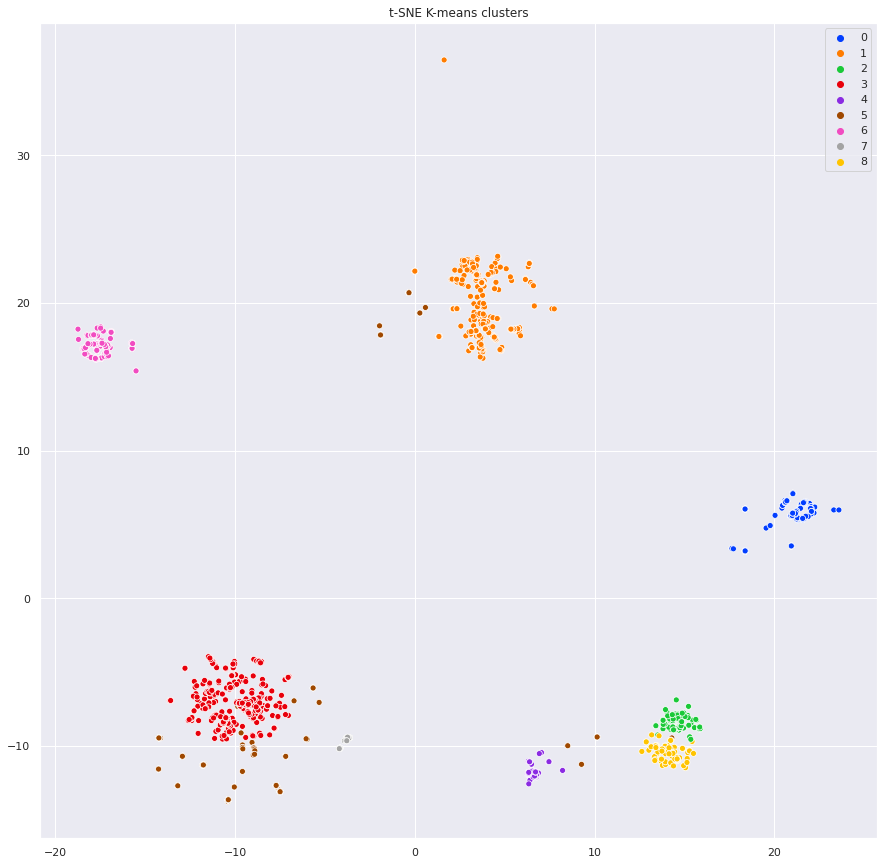

In [24]:
plot_tsne(xtrain_ctv, ytrain, 200, train_df)

In [81]:
from eli5 import show_weights
import eli5
# feature weights as df!
explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, 
feature_names=ctv.get_feature_names())
# show_weights(clf, target_names=class_dict, vec=ctv)
# show_weights(clf, vec=ctv, top=25, feature_filter=lambda x: x != '<BIAS>', target_names=class_dict)

In [82]:
explanation.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [80]:
# Bokeh
from bokeh.io import show, output_file
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from IPython.display import display, HTML

# tsne = TSNE(perplexity=50, learning_rate=1000, 
#             early_exaggeration=8.0, n_iter=1000, random_state=0, metric='l2')
# x_tsne = tsne.fit_transform(xtrain_ctv)
# test_tsne = tsne.fit_transform(xtest_ctv)
output_file('plot.html')
source_train = ColumnDataSource(
        data=dict(
            x = x_tsne[:,0],
            y = x_tsne[:,1],
            desc = ytrain,
            colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 
                      255*mpl.cm.jet(mpl.colors.Normalize()(ytrain))],
            coll_date = train_df['Collection_Date'],
            gb_title = train_df['GenBank_Title'],
            sp = train_df['Host']
        )
    )

source_test = ColumnDataSource(
        data=dict(
            x = test_tsne[:,0],
            y = test_tsne[:,1],
            desc = ytest,
            coll_date = test_df['Collection_Date'],
            gb_title = test_df['GenBank_Title'],
            sp = test_df['Host']
        )
    )

hover_tsne = HoverTool(names=["test", "train"], tooltips=[("Cluster", "@desc"), 
                                 ("Collection date", "@coll_date"), 
                                 ("Genbank_title", "@gb_title"), 
                                 ("Host", "@sp")])
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset', 'save']
plot_tsne = figure(plot_width=600, plot_height=600, tools=tools_tsne, title='t-SNE orf1ab')
plot_tsne.legend.location = "top_left"

# plot_tsne.square('x', 'y', size=7, fill_color='orange', 
#                  alpha=0.9, line_width=0, source=source_test, name="test")
plot_tsne.circle('x', 'y', size=10, fill_color='colors', 
                 alpha=0.5, line_width=0, source=source_train, name="train", legend_field='desc')

# show(plot_tsne)
display(HTML('plot.html'))